In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
#from __future__ import print_function, division

import torch
print(torch.version.cuda)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import ConcatDataset
plt.ion()   # interactive mode


9.0


In [2]:
resize = 224
crop = 224#320
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(resize),
        transforms.CenterCrop(crop),
        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
        #transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(resize),
        transforms.CenterCrop(crop),
        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
        #transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = r'adoption_folders'
image_dataset1 = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
image_dataset1_val = datasets.ImageFolder( os.path.join(data_dir, 'val'),data_transforms['val'])

dataloaders_train = torch.utils.data.DataLoader(image_dataset1,
                                                batch_size=16,
                                             shuffle=True, num_workers=4)
dataloaders_val = torch.utils.data.DataLoader(image_dataset1_val,
                                                batch_size=16,
                                             shuffle=True, num_workers=4)

class_names = image_dataset1.classes
dataloaders = {'train':dataloaders_train,'val':dataloaders_val}
dataset_sizes = {'train':len(dataloaders['train'].dataset),'val':len(dataloaders['val'].dataset)}
print('Dataset sizes: ',dataset_sizes)

Dataset sizes:  {'train': 43659, 'val': 14652}


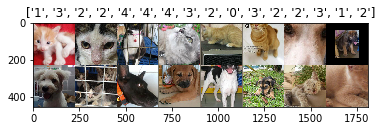

In [3]:
from resnet18_experiments import *
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])#,save_as = 'trained_models/224x224')

In [4]:
def train_kappa(model, optimizer, scheduler, num_epochs=25,dataloaders={'t':1,'v':2} ):
    since = time.time()
    dataset_sizes = {'train':len(dataloaders['train'].dataset),'val':len(dataloaders['val'].dataset)}
    print('Dataset sizes: ',dataset_sizes)
    val_acc_history = []
    train_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = kappa_loss(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [5]:
def kappa_loss(p, y, device = device,n_classes=5, eps=1e-10):
    """
    QWK loss function as described in https://arxiv.org/pdf/1612.00775.pdf
    
    Arguments:
        p: a tensor with probability predictions, [batch_size, n_classes],
        y, a tensor with one-hot encoded class labels, [batch_size, n_classes]
    Returns:
        QWK loss
    """
    #print(p,y)
    #print(p.shape[0])
    batch_size = p.shape[0]
    y_onehot = torch.FloatTensor(batch_size, n_classes).to(device)
    #print(y.size()[0])
# torch.Size([101])   

    y_x = y.view(y.size()[0], 1)
    #y_x = y_x.type(torch.cuda.FloatTensor)
    #yt = y.t()
    #print(y_x)
    #print(y_onehot)
# In your for loop
    y_onehot.zero_()
    #print(y_onehot)
    y_onehot.scatter_(1, y_x, 1.)

    #print(y)
    #print(y_onehot)
    W = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            W[i,j] = (i-j)**2
    
    W = torch.from_numpy(W.astype(np.float32)).to(device)
    
    O = torch.matmul(y_onehot.t(), p)
    E = torch.matmul(y_onehot.sum(dim=0).view(-1,1), p.sum(dim=0).view(1,-1)) / O.sum()
    out = (W*O).sum() / ((W*E).sum() + eps)
    #print(O.type(),E.type(),out.type(),out)
    
    return out

In [6]:
num_epochs = 5
model_2 = models.resnet18(pretrained=True)
for param in model_2.parameters():
    param.requires_grad = False
#pooling_size = tuple([int(x/32) for x in [crop,crop]])
#model_2.avgpool=nn.AvgPool2d(7,stride=1) #(33,12), stride=1)
#model_2.avgpool=nn.AvgPool2d(pooling_size, stride=1)
model_2.fc = nn.Linear(512,len(class_names))
model_2 = model_2.to(device)
#model_ft = model_newinput.to(device)
#criterion = kappa_loss() #nn.MSELoss()#nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)
model_2, val_hist,train_hist = train_kappa(model_2, optimizer_2, exp_lr_scheduler,
                       num_epochs=num_epochs,dataloaders=dataloaders)

Dataset sizes:  {'train': 43659, 'val': 14652}
Epoch 0/4
----------
train Loss: -27245.5328 Acc: 0.1681
val Loss: -54153.6569 Acc: 0.1992

Epoch 1/4
----------
train Loss: -82147.6230 Acc: 0.1673
val Loss: -108420.2762 Acc: 0.1959

Epoch 2/4
----------
train Loss: -137050.2420 Acc: 0.1674
val Loss: -166010.8022 Acc: 0.1906

Epoch 3/4
----------
train Loss: -191991.4298 Acc: 0.1681
val Loss: -220497.2692 Acc: 0.1974

Epoch 4/4
----------
train Loss: -246914.0723 Acc: 0.1686
val Loss: -273448.4881 Acc: 0.1906

Training complete in 26m 11s
Best val Acc: 0.199154


In [10]:
model_2.parameters()

TypeError: 'generator' object is not subscriptable

In [5]:
len(class_names)

5

In [10]:
torch.save(model_2, 'resnet18pretrained__petfinder'+str(crop)+'_'+str(num_epochs)+'epochs.pth')

In [14]:
inputs[1]

tensor([[[-0.3541, -0.5938, -0.7993,  ..., -1.6213, -1.6213, -1.6384],
         [-0.5424, -0.6109, -0.6281,  ..., -1.6555, -1.6384, -1.6555],
         [-0.3883, -0.4397, -0.4397,  ..., -1.6727, -1.6727, -1.6727],
         ...,
         [-1.3987, -1.4329, -1.5014,  ..., -0.0287, -0.0116,  0.0056],
         [-1.4500, -1.5357, -1.6042,  ..., -0.0458, -0.0287, -0.0287],
         [-1.5528, -1.6213, -1.6898,  ..., -0.0629, -0.0458, -0.0458]],

        [[-0.3550, -0.6001, -0.7927,  ..., -1.7381, -1.7381, -1.7556],
         [-0.5476, -0.6176, -0.6527,  ..., -1.7381, -1.7556, -1.7731],
         [-0.4776, -0.4776, -0.4776,  ..., -1.7556, -1.7906, -1.7906],
         ...,
         [-1.3529, -1.3880, -1.4580,  ..., -0.3025, -0.2850, -0.2675],
         [-1.4055, -1.4930, -1.5630,  ..., -0.3200, -0.3025, -0.3025],
         [-1.5105, -1.5805, -1.6506,  ..., -0.3375, -0.3200, -0.3200]],

        [[-0.4101, -0.6541, -0.8110,  ..., -1.4733, -1.4733, -1.4907],
         [-0.6018, -0.6715, -0.6541,  ..., -1

In [15]:
classes

tensor([3, 4, 1, 4, 1, 3, 3, 2, 3, 3, 3, 1, 4, 3, 3, 2])